# Kernel regression and KNN on temperature demo

In this demo, we will illustrate how to use kernel regression on climate data.  The climate data has a natural spatial structure that will be easy to illustrate the kernel regression


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Downloading and Visualizing the Data
There are several excellent sources for climate data.  In this demo, we will use the data from the [Berkeley Earth webpage](https://berkeleyearth.org/data/) which has a rich set of temperature data across time and space.  We can download the file with the following command.  This file is large -- about 455 MB.  But, it should go quickly if you are using Google Colab.

In [63]:

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import os

url = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Gridded/Land_and_Ocean_LatLong1.nc'
local_filename = url.split('/')[-1]

# Stream download with progress bar
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024 * 1024  # 1 MB chunks
    with open(local_filename, 'wb') as f, tqdm(
        total=total_size, unit='B', unit_scale=True, desc=local_filename
    ) as bar:
        for chunk in r.iter_content(chunk_size=block_size):
            f.write(chunk)
            bar.update(len(chunk))

print(f"\n✅ Download complete: {local_filename}")


Land_and_Ocean_LatLong1.nc: 100%|██████████| 455M/455M [02:01<00:00, 3.74MB/s] 


✅ Download complete: Land_and_Ocean_LatLong1.nc


The file downloaded is a NetCDF (`.nc`) file, which is a standardized format for storing multidimensional scientific data—like temperature, pressure, or wind—across space and time. It’s commonly used in climate science and remote sensing because it efficiently organizes large datasets with rich metadata and coordinate systems.  We can print the attributes of the file as follows which shows that the data is indexed over longtitude, latitude, and time, and has the `temperature` and `land_mask` in each time and space location.


In [64]:
# Load the .nc file using xarray
ds = xr.open_dataset(local_filename)
print(ds)

<xarray.Dataset> Size: 548MB
Dimensions:      (latitude: 180, longitude: 360, time: 2100, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude     (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time         (time) float64 17kB 1.85e+03 1.85e+03 ... 2.025e+03 2.025e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 518kB ...
    temperature  (time, latitude, longitude) float32 544MB ...
    climatology  (month_number, latitude, longitude) float32 3MB ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               09-Jan-2025 20:35:17
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   04-Jan-2025 19:11:11
    ocean_source_history:  06-Jan-2025 11:47:59
    com

Now, let's get a particular time slice around the year 2020.  We will also get the latitude and longtitude.  We can see that the temperature array `temp` is a `(180,360)` matrix corresponding to the temperature at the latitude and longitudes of 1 degrees steps.  The following code computes:
* `clim`:  The average monthly temperature for a given month
* `temp` : The so-called *anomoly* meaning the difference in temperature relative to the monthly average
* `temp_abs`:  The absolute temperature = `temp + clim`.

In [70]:
temp = ds['temperature'].sel(time=np.datetime64('2020-01-01'), method='nearest').values
lat = ds['latitude'].values
lon = ds['longitude'].values

month_index = 0  # January (0-based index)
clim = ds['climatology'].isel(month_number=month_index).values

temp_abs = temp + clim


print(temp.shape, lat.shape, lon.shape)

(180, 360) (180,) (360,)


Next, let's plot the temperature and temperature anomoly.

Text(0, 0.5, 'Latitude')

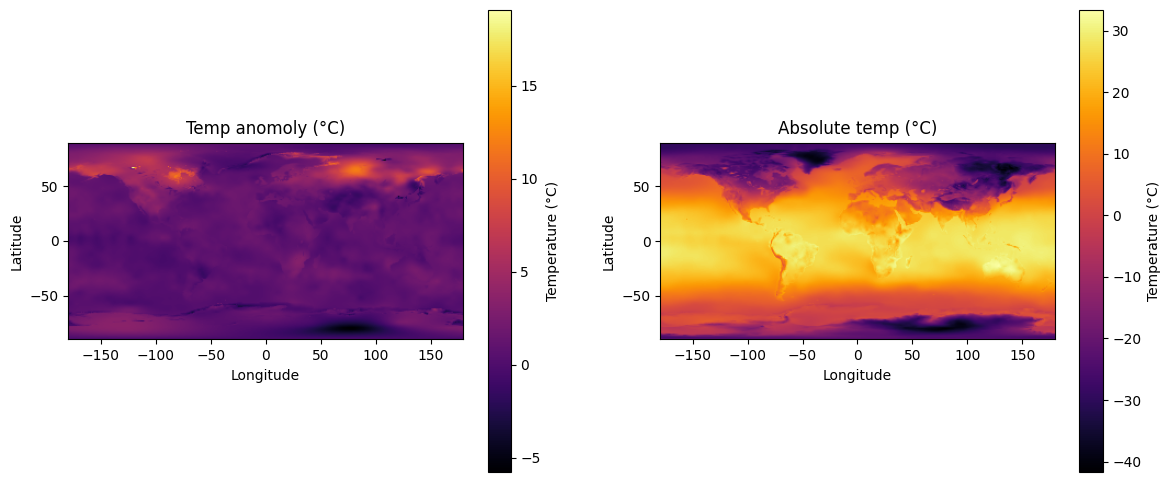

In [86]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
im = plt.imshow(temp, origin='lower', cmap='inferno',
                extent=[ds.longitude.min(), ds.longitude.max(),
                        ds.latitude.min(), ds.latitude.max()])
plt.colorbar(im, label='Temperature (°C)')
plt.title('Temp anomoly (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1,2,2)
im = plt.imshow(temp_abs, origin='lower', cmap='inferno',
                extent=[ds.longitude.min(), ds.longitude.max(),
                        ds.latitude.min(), ds.latitude.max()])
plt.colorbar(im, label='Temperature (°C)')
plt.title('Absolute temp (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


We can also plot the data on spherical projection.

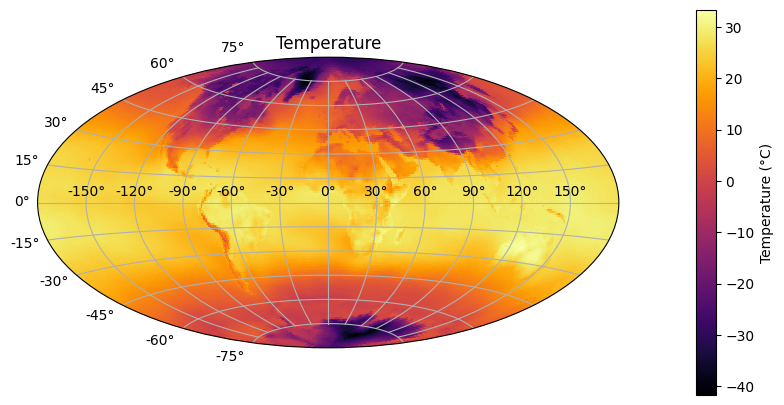

In [87]:

# Convert coordinates to radians
lon_rad = np.deg2rad(lon)  # shift to [-180, 180] then to radians
lat_rad = np.deg2rad(lat)

# Create meshgrid
lon_grid, lat_grid = np.meshgrid(lon_rad, lat_rad)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='aitoff')
im = ax.pcolormesh(lon_grid, lat_grid, temp_abs, cmap='inferno', shading='auto')
ax.grid(True)
plt.title('Temperature')
plt.colorbar(im, label='Temperature (°C)', pad=0.1)




## Getting Data over Time
To illustrate K-NN and Kernel Regression on 1D data, let's also get the data at one point over time.

Text(0.5, 1.0, 'Temperature Anomaly in NYC (40.7N, -74.0E)')

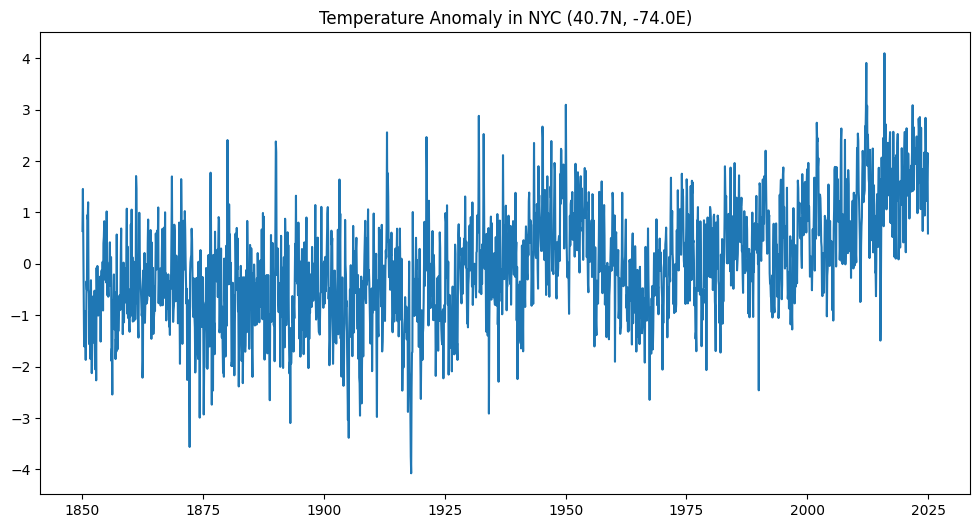

In [89]:
lat_nyc = 40.7
lon_nyc = -74.0
temp_nyc = ds['temperature'].sel(latitude=lat_nyc, longitude=lon_nyc, method='nearest').values
time = ds['time'].values
plt.figure(figsize=(12, 6))
plt.plot(time, temp_nyc)
plt.title(f'Temperature Anomaly in NYC ({lat_nyc}N, {lon_nyc}E)')


array([ 0.6372255 ,  1.4553667 ,  0.33717617, -0.95638627, -1.6067266 ,
       -1.3862772 , -0.91861904, -1.5261823 , -1.8699269 , -1.4305115 ],
      dtype=float32)

## Fitting data with KNN

To demonstrate K-NN, let's first randomly select a fraction `p=0.1` of spatial points and try to interpoate the temperature to the remain `1-p` fraction.

In [79]:
temp_flat = temp_abs.flatten()
nlat = len(lat)
nlog = len(lon)

# Create a grid of latitude and longitude points
lat_flat = np.repeat(lat, len(lon))
lon_flat = np.tile(lon, len(lat))   

# Convert the lat/long to Cartesian coordinates for distance calculation
# We use a unit sphere (R=1) for simplicity
R = 1  
x = R * np.cos(np.deg2rad(lat_flat)) * np.cos(np.deg2rad(lon_flat))
y = R * np.cos(np.deg2rad(lat_flat)) * np.sin(np.deg2rad(lon_flat))
z = R * np.sin(np.deg2rad(lat_flat))

# Select a random subset of points for training
p = 0.03  # fraction of points to use for training
num_points = len(temp_flat)
num_train = int(p * num_points)
np.random.seed(0)  # for reproducibility
train_indices = np.random.choice(num_points, num_train, replace=False)
test_indices = np.setdiff1d(np.arange(num_points), train_indices)
X_train = np.vstack((x[train_indices], y[train_indices], z[train_indices])).T
y_train = temp_flat[train_indices]
X_test = np.vstack((x[test_indices], y[test_indices], z[test_indices])).T
y_test = temp_flat[test_indices]

Now, let's do K-NN for K=1 and measure the MAE

In [80]:
k = 1
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (k={k}): {mae:.2f} °C")

Mean Absolute Error (k=1): 1.60 °C


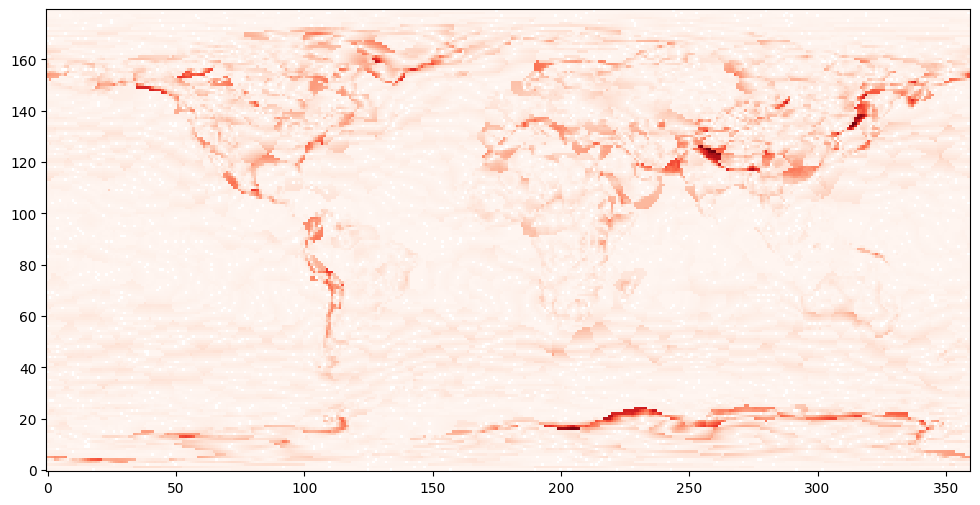

In [81]:
# Let's visualize the prediction error
error = np.full(num_points, np.nan)
error[test_indices] = np.abs(y_test - y_pred)
plt.figure(figsize=(12, 6))
im = plt.imshow(error.reshape(temp_abs.shape), origin='lower', cmap='Reds', interpolation='nearest')

Now let's try different K values.  For each K value we plot the training and test error.

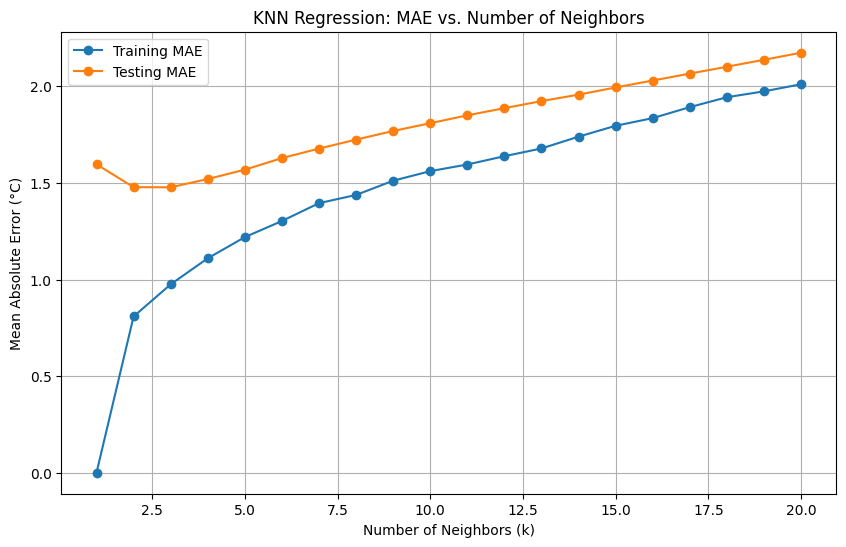

In [97]:
k_test = np.arange(1, 21)
train_errors = []
test_errors = []
for k in k_test:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_errors.append(train_mae)
    test_errors.append(test_mae)

plt.figure(figsize=(10, 6))
plt.plot(k_test, train_errors, label='Training MAE', marker='o')
plt.plot(k_test, test_errors, label='Testing MAE', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (°C)')
plt.title('KNN Regression: MAE vs. Number of Neighbors')
plt.legend()
plt.grid()
plt.show()

## Kernel Smoother


We can now try the same experiment with kernel smoother (i.e., Nadaraya-Watson) varying the bandwidth.

In [98]:
def nadaraya_watson(X_train, y_train, X_query, bandwidth):
    from scipy.spatial.distance import cdist
    distances = cdist(X_query, X_train)
    weights = np.exp(- (distances ** 2) / (2 * bandwidth ** 2))
    weights_sum = np.sum(weights, axis=1, keepdims=True)
    weights_sum[weights_sum == 0] = 1e-10
    weights /= weights_sum
    y_pred = weights.dot(y_train)
    return y_pred

Bandwidth: 0.010, Test MAE: 1.51 °C
Bandwidth: 0.020, Test MAE: 1.41 °C
Bandwidth: 0.030, Test MAE: 1.38 °C
Bandwidth: 0.040, Test MAE: 1.45 °C
Bandwidth: 0.050, Test MAE: 1.56 °C
Bandwidth: 0.060, Test MAE: 1.71 °C
Bandwidth: 0.070, Test MAE: 1.87 °C
Bandwidth: 0.080, Test MAE: 2.04 °C
Bandwidth: 0.090, Test MAE: 2.20 °C
Bandwidth: 0.100, Test MAE: 2.35 °C


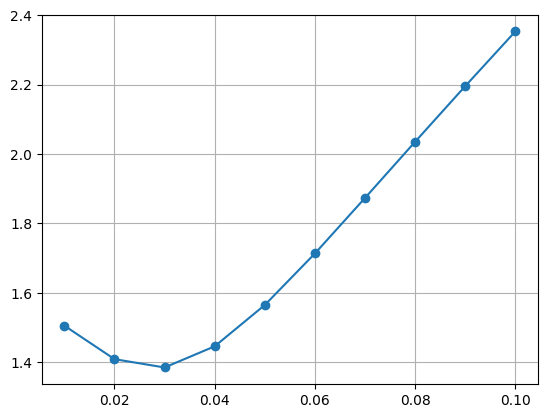

In [ ]:
bandwidths = np.linspace(0.01, 0.1, 10)
test_errors = []
for bw in bandwidths:
    y_pred = nadaraya_watson(X_train, y_train, X_test, bandwidth=bw)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_errors.append(test_mae)
    print(f"Bandwidth: {bw:.3f}, Test MAE: {test_mae:.2f} °C")


In [94]:
from sklearn.kernel_ridge import KernelRidge

bandwidths = np.linspace(0.01,2.0, 20)
test_errors = []
for bw in bandwidths:
    kr = KernelRidge(kernel='rbf', gamma=1/(2*bw**2))
    kr.fit(X_train, y_train)
    y_test_pred = kr.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_errors.append(test_mae)
    print(f"Bandwidth: {bw:.3f}, Test MAE: {test_mae:.2f} °C")

Bandwidth: 0.01, Test MAE: 16.08 °C
Bandwidth: 0.11473684210526315, Test MAE: 2.67 °C
Bandwidth: 0.21947368421052632, Test MAE: 2.17 °C
Bandwidth: 0.3242105263157895, Test MAE: 2.51 °C
Bandwidth: 0.42894736842105263, Test MAE: 2.96 °C
Bandwidth: 0.5336842105263158, Test MAE: 3.29 °C
Bandwidth: 0.638421052631579, Test MAE: 3.53 °C
Bandwidth: 0.7431578947368421, Test MAE: 3.75 °C
Bandwidth: 0.8478947368421053, Test MAE: 3.93 °C
Bandwidth: 0.9526315789473684, Test MAE: 4.13 °C
Bandwidth: 1.0573684210526315, Test MAE: 4.36 °C
Bandwidth: 1.1621052631578948, Test MAE: 4.57 °C
Bandwidth: 1.266842105263158, Test MAE: 4.75 °C
Bandwidth: 1.371578947368421, Test MAE: 4.88 °C
Bandwidth: 1.4763157894736842, Test MAE: 5.00 °C
Bandwidth: 1.5810526315789473, Test MAE: 5.10 °C
Bandwidth: 1.6857894736842105, Test MAE: 5.18 °C
Bandwidth: 1.7905263157894737, Test MAE: 5.27 °C
Bandwidth: 1.8952631578947368, Test MAE: 5.34 °C
Bandwidth: 2.0, Test MAE: 5.42 °C


Text(0, 0.5, 'Mean Absolute Error (°C)')

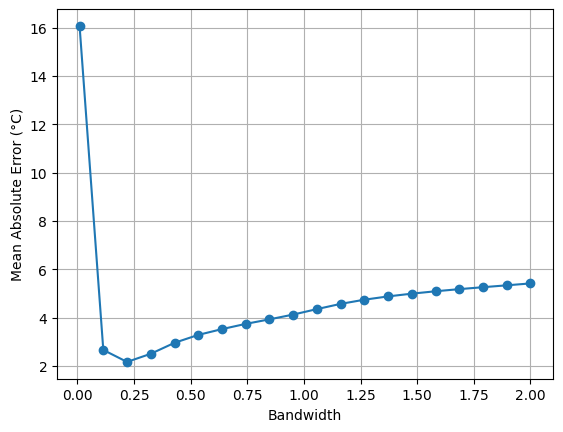

In [96]:
plt.plot(bandwidths, test_errors, marker='o')
plt.grid()
plt.xlabel('Bandwidth')
plt.ylabel('Mean Absolute Error (°C)')


In [ ]:
im = np.argmin(test_errors)
best_bw = bandwidths[im]
